In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import xgcm
import xarray as xr
import sectionate
import regionate
import matplotlib.pyplot as plt

## 0. Loading and exploring CM4 ocean diagnostics

In [3]:
from example_dataset_grids import load_CM4p25
grid = load_CM4p25()
grid._ds = grid._ds.chunk({"xh":-1, "yh":-1, "xq":-1, "yq":-1, "z_l":1})
ds = grid._ds

/work/hfd/.conda/envs/CM4X/lib/python3.12/site-packages/xarray/core/dataset.py:273: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


We want to must verify that the diagnosed advective heat tendencies (flux convergence) are column-wise consistent with the convergence computed offline from fluxes on the cell faces.

/work/hfd/.conda/envs/CM4X/lib/python3.12/site-packages/xgcm/grid_ufunc.py:836: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/work/hfd/.conda/envs/CM4X/lib/python3.12/site-packages/xgcm/grid_ufunc.py:836: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg


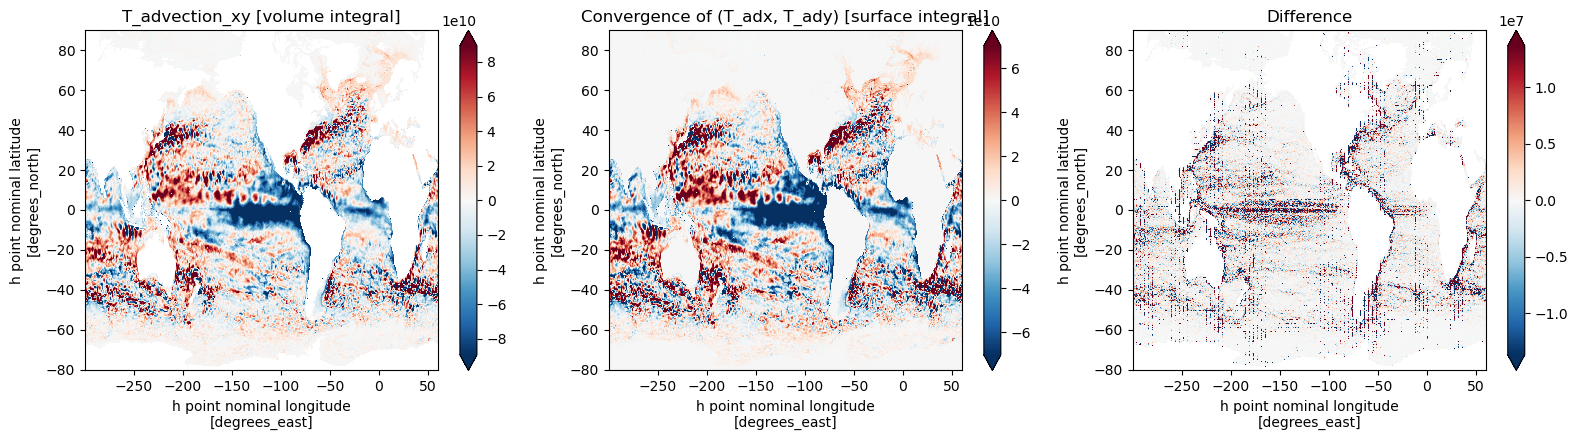

In [4]:
dheatdt_dynamics = (ds['T_advection_xy']*ds['areacello']).sum('z_l')
dheatdt_dynamics = dheatdt_dynamics.where(dheatdt_dynamics!=0.)

plt.figure(figsize=(16, 4.5))
plt.subplot(1,3,1)
dheatdt_dynamics.plot(robust=True)
plt.title("T_advection_xy [volume integral]")

T_adv_heating = -(grid.diff(ds['T_adx'].sum("z_l"), "X") + grid.diff(ds['T_ady'].sum("z_l"), "Y"))
plt.subplot(1,3,2)
T_adv_heating.plot(robust=True)
plt.title("Convergence of (T_adx, T_ady) [surface integral]")

plt.subplot(1,3,3)
(dheatdt_dynamics-T_adv_heating).plot(robust=True)
plt.title("Difference");
plt.tight_layout()

These relative errors are on the order of 10$^{-5}$, which is consistent with the single precision format of the outputs.

## 1. Determine a mask for the region of interest.

Let us consider the heat budget for the coldest regions of the high arctic (excluding the Southern Ocean), which have an annual-mean temperature that is below the freezing point of 0ºC (for freshwater at surface air pressure).

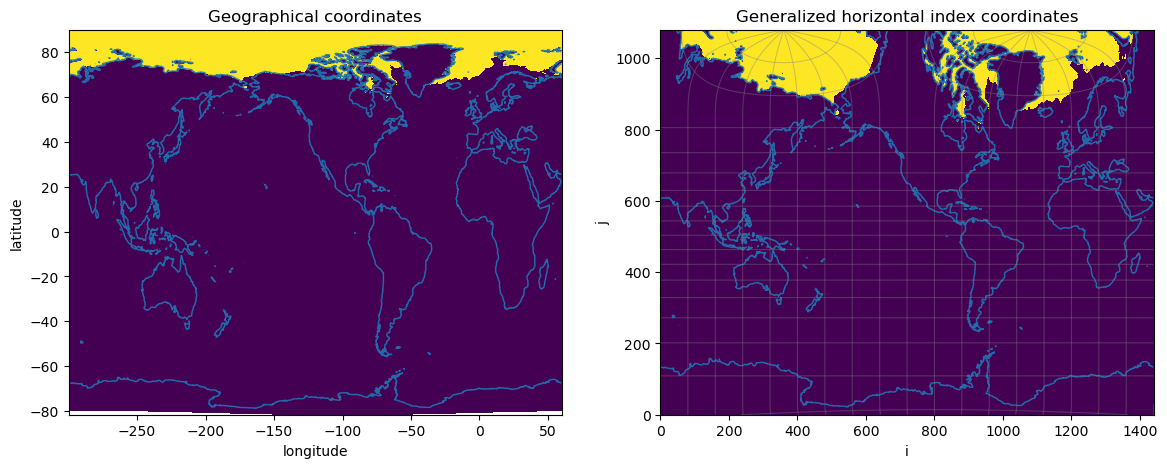

In [5]:
ds['mask'] = (
    (ds['thetao'].isel(z_l=0, time=0) < 0.) &
    (ds['geolat'] > 0)
)
plt.figure(figsize=(14, 5))
plt.subplot(1,2,1)
plt.pcolor(
    ds.geolon_c,
    ds.geolat_c,
    ds.mask,
    vmin=0.2, vmax=1.
)
plt.contour(
    ds.geolon,
    ds.geolat,
    ds.deptho,
    levels=[0.],
    colors="C0",
    linewidths=1.,
    alpha=0.9
)
plt.title("Geographical coordinates")
plt.xlabel("longitude")
plt.ylabel("latitude")

plt.subplot(1,2,2)
plt.pcolor(
    ds.mask
)
plt.contour(
    ds.deptho,
    levels=[0.],
    colors="C0",
    linewidths=1.,
    alpha=0.9
)
dlon=20.
plt.contour(
    ds['geolon_c'],
    colors="grey",
    linestyles="solid",
    linewidths=0.75,
    alpha=0.4,
    levels=np.arange(-300., 60.+dlon, dlon)
)

dlat = 10.
plt.contour(
    ds['geolat_c'],
    colors="grey",
    linestyles="solid",
    linewidths=0.75,
    alpha=0.4,
    levels=np.arange(-90., 90.+dlat, dlat)
);
plt.title("Generalized horizontal index coordinates")
plt.xlabel("i")
plt.ylabel("j");

## 2. We use `regionate` to find the sections that bound the region

On the backend, this approach uses `countourpy` to find the demical indices of the contours of the mask in index space, and then convert these into the corresponding integer indices of the ocean model's vorticity grid (corners of C-grid tracer cells). 

In [6]:
from regionate import MaskRegions
region_dict = MaskRegions(ds.mask, grid).region_dict

We plot both the indices and geographical coordinates to verify that these points indeed *exactly* bound the mask.

**Note:** Because of the tripolar grid folds at high latitudes, `regionate` splits the mask in two (as seen by two separate large regions in index space, which are adjacent but separate by a vertical line of indices in geographical coordinates. This does not affect our estimates of the transport, however, because the two sets of fluxes normal to the fold are exactly opposite, and thereby cancel when added together (as below).


While the region is mostly made up of two large closed sub-regions (in index space),
there are actually 162 other smaller regions that make up external islands
or internal holes in the mask! This method also carefully takes each of those into account.


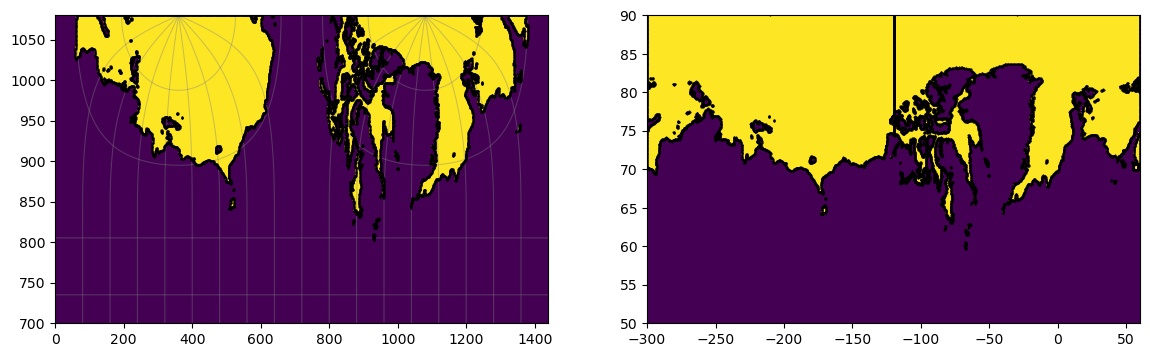

In [7]:
plt.figure(figsize=(14, 4))
plt.subplot(1,2,1)
plt.pcolor(
    region_dict[0].mask,
)
dlon=20.
plt.contour(
    ds['geolon_c'],
    colors="grey",
    linestyles="solid",
    linewidths=0.75,
    alpha=0.4,
    levels=np.arange(-300., 60.+dlon, dlon)
)

dlat = 10.
plt.contour(
    ds['geolat_c'],
    colors="grey",
    linestyles="solid",
    linewidths=0.75,
    alpha=0.4,
    levels=np.arange(-90., 90.+dlat, dlat)
);

plt.ylim(700, None)
for p, region in enumerate(region_dict.values()):
    plt.plot(region.i, region.j, "k.", markersize=1)
    
plt.subplot(1,2,2)
plt.pcolor(
    ds.geolon_c,
    ds.geolat_c,
    region_dict[0].mask,
)
plt.ylim(50, None)
for p, region in enumerate(region_dict.values()):
    plt.plot(region.lons, region.lats, "k.", markersize=1)

print(f"""
While the region is mostly made up of two large closed sub-regions (in index space),
there are actually {len(region_dict)-2} other smaller regions that make up external islands
or internal holes in the mask! This method also carefully takes each of those into account.""")

## 3. We use `sectionate` to compute the advective heat fluxes that converge into the region.

In [8]:
total_convergent_heat_transport = 0.

for p, region in enumerate(region_dict.values()):
    ds_sec = sectionate.convergent_transport(
        grid,
        region.i,
        region.j,
        utr="T_adx",
        vtr="T_ady",
        layer="z_l",
        interface="z_i",
        outname="conv_heat_transport",
        positive_in=region.mask,
    )
    
    region.convergent_heat_transport = ds_sec['conv_heat_transport'].sum("z_l").isel(time=0).compute()
    
    total_convergent_heat_transport += region.convergent_heat_transport.sum(["sect"]).values


In [9]:
print(f"The total advective heat convergence in these cold regions of the Arctic is: {total_convergent_heat_transport*1e-12} TW")

The total advective heat convergence in these cold regions of the Arctic is: 77.52990691977377 TW


## 4. We verify our calculation by comparing against the volume integral of the masked tendency terms

In [10]:
dheatdt_dynamics = (ds['T_advection_xy']*ds['areacello']).sum('z_l')
dheatdt_dynamics = dheatdt_dynamics.where(dheatdt_dynamics!=0.)

advective_heating_rate = dheatdt_dynamics.where(region_dict[0].mask).sum(["xh", "yh"]).isel(time=0).values

In [11]:
percent_error = np.round(np.abs((total_convergent_heat_transport - advective_heating_rate)/advective_heating_rate)*100, 4)
print(f"""
Our calculation of the total heat flux converging into the region is within {percent_error}%
of the {advective_heating_rate*1e-12} TW value computed from the more direct advective heat tendency diagnostic,
giving us confidence in our calculations.
""")


Our calculation of the total heat flux converging into the region is within 0.0001%
of the 77.529830391808 TW value computed from the more direct advective heat tendency diagnostic,
giving us confidence in our calculations.



## 5. The pay-off: understanding advective tendencies by tracing them back to boundary fluxes

Where this flexible convergent-flux-integral approach becomes powerful is when we unravel the cross-boundary integral to reveal the spatial (and temporal) pattern of the heat fluxes into the region. This is a particularly powerful tool for oceanographic problems, where very strong anisotropies due to bathymetric variations, surface forcings, and emergent dynamical structures (boundary currents, jets, eddies, etc.) cause fluxes to vary several orders of magnitude and are often dominated by a few localized hot spots.

Below, we visualize the spatial structure of the heat fluxes into the biggest of the sub-regions.

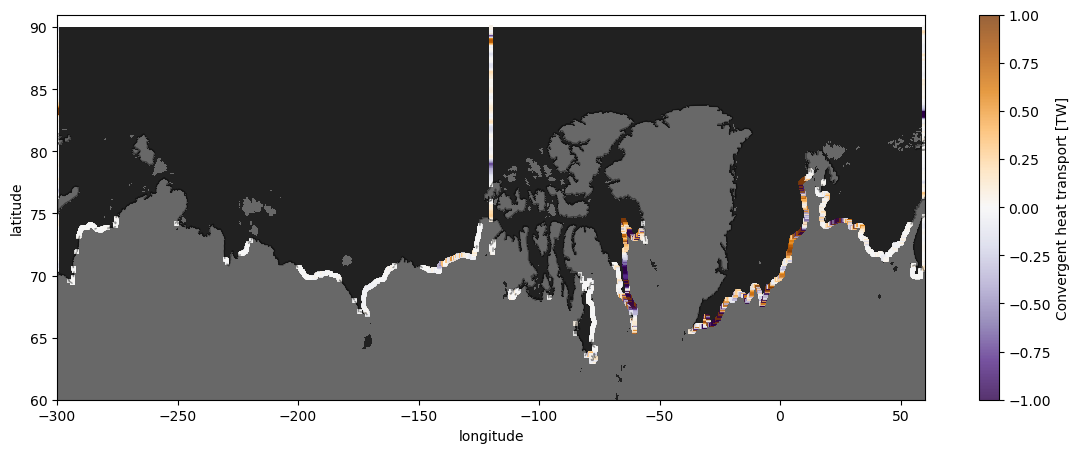

In [12]:
vmax = 1
plt.figure(figsize=(14,5))

plt.pcolor(
    ds.geolon_c,
    ds.geolat_c,
    region_dict[0].mask,
    cmap="Greys",
    vmin=-3, vmax=1.5
)

for p, region in enumerate(region_dict.values()):
    if len(region.lons) < 100: continue
    plt.plot(
        region.convergent_heat_transport['lon'].where(region.convergent_heat_transport==0.),
        region.convergent_heat_transport['lat'].where(region.convergent_heat_transport==0.),
        "k-", lw=1., alpha=0.4
    )
for p, region in enumerate(region_dict.values()):
    if len(region.lons) < 100: continue
    sc = plt.scatter(
        region.convergent_heat_transport['lon'],
        region.convergent_heat_transport['lat'],
        c = ((region.convergent_heat_transport*1e-12)
             .where(region.convergent_heat_transport!=0.)),
        marker="s",
        s = 10,
        cmap="PuOr_r",
        vmin=-vmax,
        vmax=vmax,
        edgecolor="k",
        linewidth=0.,
        alpha=0.8
    )
        
plt.colorbar(sc, label="Convergent heat transport [TW]")
plt.ylabel("latitude")
plt.xlabel("longitude");
plt.ylim(60, 91);